As ET resolution is 1,8 visual angle and approximate smallest facial AOI area (nose in most cases) is 5.1 cm (11,25 cm^2) ⇒ maximum real world distance should be 162 cm. I can measure the pixel size of an AOI if i make some recordings where both people are not moving on that distance and calculate the pixel size of an AOI. Consequently filter AOIs which are smaller than that and not count them in the analysis.

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

In [2]:
# loading files from a recording of a face on the 162 cm distance and from the FaceMapper

recording_path = "/Users/alina/Downloads/Thesis/Facial landmarks test"
face_detections_file =  os.path.join(recording_path, "face_detections.csv")
fixations_file = os.path.join(recording_path, "fixations.csv")
face_file = os.path.join(recording_path, "fixations_on_face.csv")

face_detections_df = pd.read_csv(face_detections_file)
fixations_df = pd.read_csv(fixations_file)
face_df = pd.read_csv(face_file)

In [3]:
face_with_coordinates_df = pd.merge(
    fixations_df,
    face_df,
    on="start timestamp [ns]",
    how="inner"  # or "left" if you want to keep all fixations and NaNs for unmatched
)

# leave only fixations on face
face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

#face_with_coordinates_df.head()
#print(len(face_with_coordinates_df))

### functions ###

# there are already AOI centers for eyes and nose provided by FaceMapper

## to find mouth centre point

def mouth_centre(m_left_x, m_left_y, m_right_x, m_right_y):
    # Calculate the center of the mouth by averaging the x and y coordinates
    mouth_x = (m_left_x + m_right_x) / 2
    mouth_y = (m_left_y + m_right_y) / 2
    return mouth_x, mouth_y


## to assign aois based on voronoi method for each row

def which_aoi(fix_x, fix_y, aoi_centers):
    
    """ Assigns the fixation to the nearest AOI center using Euclidean distance. """

    min_dist = float('inf')
    closest_aoi = None

    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        dist = np.sqrt((fix_x - aoi_x)**2 + (fix_y - aoi_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_aoi = aoi_id

    return closest_aoi


## to illustrate the results

def plot_fixation_and_aois(fix_x, fix_y, aoi_centers, assigned_aoi):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Plot AOI centers
    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        ax.plot(aoi_x, aoi_y, 'o', label=aoi_id)
        ax.text(aoi_x + 5, aoi_y + 5, aoi_id, fontsize=9, color='black')

    # Plot fixation point
    ax.plot(fix_x, fix_y, 'rx', label='Fixation')
    ax.text(fix_x + 5, fix_y + 5, 'Fixation', color='red')

    # Draw a line from fixation to the assigned AOI
    if assigned_aoi in aoi_centers:
        aoi_x, aoi_y = aoi_centers[assigned_aoi]
        ax.plot([fix_x, aoi_x], [fix_y, aoi_y], 'r--', label='Assigned AOI link')

    ax.set_title('Voronoi-Based AOI Assignment')
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.legend()
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Invert y-axis as working with screen coords
    plt.grid(True)
    plt.show()

Total fixations: 7
Matched fixations: 6
Unmatched fixations: 1


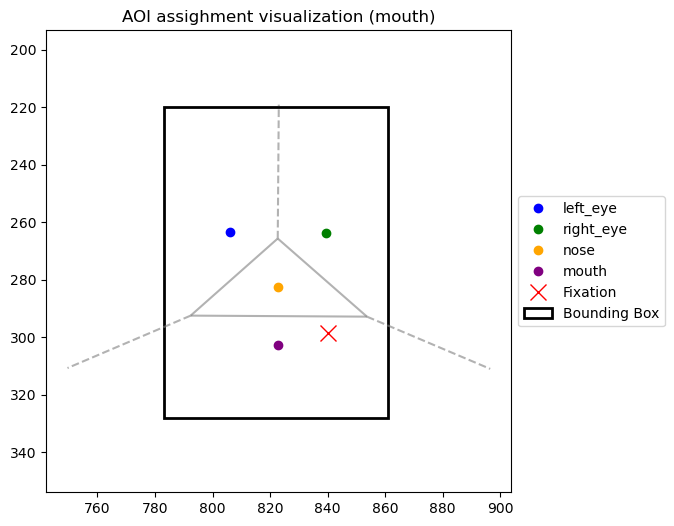

In [42]:
matched_rows = []
unmatched_fixations = 0

# Make sure timestamps are integers
face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)

# Get sorted unique timestamps
unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

for i, fixation_row in face_with_coordinates_df.iterrows():
    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]
    
    found = False
    for ts in timestamps_in_interval:
        detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]
        
        for _, det_row in detections_at_ts.iterrows():
            x1 = det_row['p1 x [px]']
            y1 = det_row['p1 y [px]']
            x2 = det_row['p2 x [px]']
            y2 = det_row['p2 y [px]']

            if x1 <= fx <= x2 and y1 <= fy <= y2:
                combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                matched_rows.append(combined)
                found = True
                break  # Only first match at this timestamp

        if found:
            break  # Stop checking further timestamps once matched

    if not found:
        unmatched_fixations += 1

print(f"Total fixations: {len(face_with_coordinates_df)}")
print(f"Matched fixations: {len(matched_rows)}")
print(f"Unmatched fixations: {unmatched_fixations}")

matched_df = pd.DataFrame(matched_rows)

assigned_aois = []

for _, row in matched_df.iterrows():
    mouth_x, mouth_y = mouth_centre(
        row['mouth left x [px]'], row['mouth left y [px]'],
        row['mouth right x [px]'], row['mouth right y [px]']
    )
    
    aoi_centers = {
        'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
        'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
        'nose': (row['nose x [px]'], row['nose y [px]']),
        'mouth': (mouth_x, mouth_y)
    }

    assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)

    #plot_fixation_and_aois(row['fixation x [px]'], row['fixation y [px]'], aoi_centers, assigned_aoi)

    assigned_aois.append(assigned_aoi)

matched_df['assigned_aoi'] = assigned_aois# Select the first row


row = matched_df.iloc[1]

# Calculate mouth center
mouth_x, mouth_y = mouth_centre(
    row['mouth left x [px]'], row['mouth left y [px]'],
    row['mouth right x [px]'], row['mouth right y [px]']
)

# Define AOI centers with colors
aoi_centers = {
    'left_eye': ((row['eye left x [px]'], row['eye left y [px]']), 'blue'),
    'right_eye': ((row['eye right x [px]'], row['eye right y [px]']), 'green'),
    'nose': ((row['nose x [px]'], row['nose y [px]']), 'orange'),
    'mouth': ((mouth_x, mouth_y), 'purple')
}

# Convert AOI coords to array for Voronoi
points = np.array([coords for coords, _ in aoi_centers.values()])

# Create Voronoi diagram
vor = Voronoi(points)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1.5, line_alpha=0.6, point_size=0)

# Plot AOI points with different colors
for label, ((x, y), color) in aoi_centers.items():
    ax.plot(x, y, 'o', color=color, label=label)

# Plot fixation point
fix_x = row['fixation x [px]']
fix_y = row['fixation y [px]']
ax.plot(fix_x, fix_y, 'rx', markersize=12, label='Fixation')

# Draw bounding box from p1 (top-left) to p2 (bottom-right)
x1 = row['p1 x [px]']
y1 = row['p1 y [px]']
x2 = row['p2 x [px]']
y2 = row['p2 y [px]']
bbox_w = x2 - x1
bbox_h = y2 - y1
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2, edgecolor='black', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

# Add legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set title and display
ax.set_title(f"AOI assighment visualization ({assigned_aois[1]})")
plt.gca().invert_yaxis()
plt.axis('equal')
#plt.tight_layout()
plt.show()



AOI: left_eye, Area: 2496.13
AOI: right_eye, Area: 2373.03
AOI: nose, Area: 826.15
AOI: mouth, Area: 2728.68


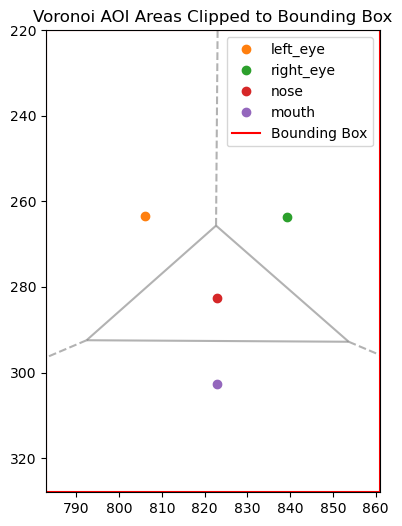

In [ ]:

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")  # <-- corrected to check for 2D
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

def compute_aoi_areas(aoi_centers, bbox_coords):
    points = np.array(list(aoi_centers.values()))
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    bbox = Polygon(bbox_coords)
    aoi_areas = {}
    for aoi_id, region in zip(aoi_centers.keys(), regions):
        polygon_points = vertices[region]
        poly = Polygon(polygon_points)
        poly_clipped = poly.intersection(bbox)
        aoi_areas[aoi_id] = poly_clipped.area
    return aoi_areas, vor, regions, vertices

# Example AOI centers
aoi_centers = {
    'left_eye': (806.013, 263.403),
    'right_eye': (839.363, 263.667),
    'nose': (822.897, 282.474),
    'mouth': (822.779, 302.7925)
}

# Correct bounding box coordinates as a list of (x, y) tuples
x1, y1, x2, y2 = 783.0, 220.0, 861.0, 328.0
bbox_coords = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

areas, vor, regions, vertices = compute_aoi_areas(aoi_centers, bbox_coords)

for aoi, area in areas.items():
    print(f"AOI: {aoi}, Area: {area:.2f}")

# Optional: Plot
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1.5, line_alpha=0.6, point_size=10)
for aoi, (x, y) in aoi_centers.items():
    ax.plot(x, y, 'o', label=aoi)
bbox_x, bbox_y = zip(*bbox_coords)
bbox_x += (bbox_x[0],)
bbox_y += (bbox_y[0],)

ax.set_xlim(min(bbox_x), max(bbox_x))
ax.set_ylim(min(bbox_y), max(bbox_y))

ax.plot(bbox_x, bbox_y, 'r-', label='Bounding Box')
ax.set_title('Voronoi AOI Areas Clipped to Bounding Box')
ax.set_aspect('equal')
plt.gca().invert_yaxis()
ax.legend()
plt.show()




In [57]:
# to get the finite (nose) area only
"""# Get the bounding box as a clipping rectangle (face bounding box)
bbox_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])

aoi_areas = {}

for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]

    # skip infinite regions - as i am interested in the nose
    if -1 in region or len(region) == 0:
        continue

    polygon_coords = [vor.vertices[i] for i in region]
    poly = Polygon(polygon_coords)

    # clip to bounding box to ensure all areas are finite and within face
    clipped_poly = poly.intersection(bbox_polygon)

    if clipped_poly.is_empty:
        continue

    aoi_label = list(aoi_centers.keys())[point_idx]
    aoi_areas[aoi_label] = clipped_poly.area

for aoi, area in aoi_areas.items():
    print(f"AOI '{aoi}' has area: {area:.2f} px²")
"""

'# Get the bounding box as a clipping rectangle (face bounding box)\nbbox_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])\n\naoi_areas = {}\n\nfor point_idx, region_idx in enumerate(vor.point_region):\n    region = vor.regions[region_idx]\n\n    # skip infinite regions - as i am interested in the nose\n    if -1 in region or len(region) == 0:\n        continue\n\n    polygon_coords = [vor.vertices[i] for i in region]\n    poly = Polygon(polygon_coords)\n\n    # clip to bounding box to ensure all areas are finite and within face\n    clipped_poly = poly.intersection(bbox_polygon)\n\n    if clipped_poly.is_empty:\n        continue\n\n    aoi_label = list(aoi_centers.keys())[point_idx]\n    aoi_areas[aoi_label] = clipped_poly.area\n\nfor aoi, area in aoi_areas.items():\n    print(f"AOI \'{aoi}\' has area: {area:.2f} px²")\n'